In [1]:
# Data processing
import warnings
import numpy as np
import pandas as pd
import datetime as dt

# Graphing
from matplotlib import pyplot as plt

# Arch
from arch import arch_model

# Statistics
from scipy.stats import norm
from scipy.stats import t as studentst
from scipy import stats


from tqdm import tqdm

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import collections

In [2]:
# Initial investment and currency per stock in dollars
investment = {
    "^HSI": [500_000, 'HKD'],  # Hang Seng Index
    "^AEX": [500_000, 'EUR'],  # AEX Index
    "^GSPC": [500_000, 'USD'],  # S&P 500 Index
    "^N225": [500_000, 'JPY']  # Nikkei 225
}

relative_weights = np.array([0.5, 0.5, 0.5, 0.5, -1.0])
absolute_weights = np.array([500_000, 500_000, 500_000, 500_000, -1_000_000])

# Get prices from start date till end date
start = "2010-01-01"
end = "2021-04-01"

df_losses = pd.read_csv('Data\LinearLosses.csv',
                        parse_dates=True, index_col=0, )

# Set up lists containing the confidence levels
confidence_levels = [0.975, 0.99]

In [3]:
df_losses.head(2)

,AEX,GSPC,HSI,N225,Bond
Date,,,,,
2010-01-05,-0.002949,-0.007167,-0.025363,-0.016715,0.000150
2010-01-06,-0.001580,0.002099,-0.003576,0.006556,0.000652


In [4]:
# Functions to calculate VaR and ES
def normal_var(mean, std, alpha):
    return mean + std * norm.ppf(alpha)


def normal_es(mean, std, alpha):
    return mean + std * norm.pdf(norm.ppf(alpha)) / (1 - alpha)


def t_var(v, mean, std, alpha):
    t_std = std / np.sqrt(v / (v-2))
    return mean + std * studentst.ppf(alpha, v)


def t_es(v, mean, std, alpha):
    t_std = std / np.sqrt(v / (v-2))
    return mean + std * studentst.pdf(studentst.ppf(alpha, v), v) / (1 - alpha) * \
        (v + studentst.ppf(alpha, v)**2) / (v-1)


def var_covar(returns, weights):
    mean = returns.mean()
    pf_mean = np.sum(mean*weights)

    cov_matrix = returns.cov()
    pf_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    return pf_mean, pf_std

def empirical_var(x, alpha):
    return np.quantile(np.sort(x), alpha, interpolation='linear')


def empirical_es(x, alpha):
    var = empirical_var(x, alpha)
    return x[x >= var].mean()

In [5]:
def VaR_VC(absolute_weights: np.ndarray, df_returns: pd.DataFrame, windows: list, drop: bool) -> pd.DataFrame:
    """Creates Value at Risk figures for Variance Covariance Methods

    Args:
        absolute_weights (np.ndarray): array with weights       
        df_returns (pd.DataFrame): dataframe with returns
        windows (list): list of windows for VaR estimation
        drop (bool): boolean to drop top 20 worst losses

    Returns:
        pd.DataFrame: dataframe with risk figures
    """

    df = pd.DataFrame(index=df_returns.index)
    df['Returns'] = np.sum(df_returns * absolute_weights, axis=1)

    if drop:
        to_drop = df.sort_values('Returns', ascending=False)[:20].index
        df = df.drop(to_drop)
        df_returns = df_returns.drop(to_drop)

    alphas = [0.975, 0.990]
    for alpha in alphas:
        for window in windows:

            means = np.empty(len(df_returns))
            stds = np.empty(len(df_returns))
            means[:] = np.NaN
            stds[:] = np.NaN
            for t in tqdm(range(window, len(df_returns))):
                means[t], stds[t] = var_covar(
                    df_returns[t-window:t], absolute_weights)
            df[f'VaR_VC_{window}_{alpha}_N'] = normal_var(means, stds, alpha)
            df[f'ES_VC_{window}_{alpha}_N'] = normal_es(means, stds, alpha)

            for dof in [5]:
                df[f'VaR_VC_{window}_{alpha}_t{dof}'] = t_var(
                    dof, means, stds, alpha)
                df[f'ES_VC_{window}_{alpha}_t{dof}'] = t_es(
                    dof, means, stds, alpha)
    df.drop('Returns', axis=1, inplace=True)
    return df

In [6]:
df_VaR_VC = VaR_VC(absolute_weights, df_losses, windows=[300], drop=False)

100%|█████████████████████████████████████████████████████████████████████████████| 1918/1918 [00:05<00:00, 379.08it/s]


<AxesSubplot:xlabel='Date'>

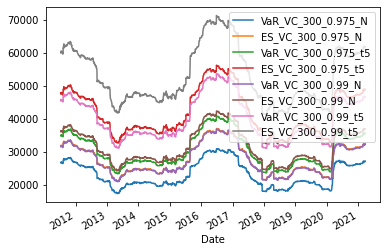

In [7]:
df_VaR_VC.plot()

In [8]:
def VaR_HS(absolute_weights: np.ndarray, df_returns: pd.DataFrame, windows: list) -> pd.DataFrame:
    """Creates Value at Risk figures for Historical Simulation method
    Args:
        absolute_weights (np.ndarray): array with weights 
        df_returns (pd.DataFrame): dataframe with returns
    """
    df = pd.DataFrame(index=df_returns.index)
    df['Returns'] = np.sum(df_returns * absolute_weights, axis=1)
    alphas = [0.975, 0.990]

    for alpha in alphas:
        for window in windows:
            df[f'VaR_HS_{window}_{alpha}_N'] = np.NaN
            df[f'ES_HS_{window}_{alpha}_N'] = np.NaN
            for t in tqdm(range(window, len(df_returns))):
                df[f'VaR_HS_{window}_{alpha}_N'].iloc[t] = empirical_var(
                    df['Returns'].iloc[t-window:t], alpha)
                df[f'ES_HS_{window}_{alpha}_N'].iloc[t] = empirical_es(
                    df['Returns'].iloc[t-window:t], alpha)
    df.drop('Returns', axis=1, inplace=True)
    return df

In [9]:
df_VaR_HS = VaR_HS(absolute_weights, df_losses, windows=[300])

100%|█████████████████████████████████████████████████████████████████████████████| 1918/1918 [00:06<00:00, 289.51it/s]


<AxesSubplot:xlabel='Date'>

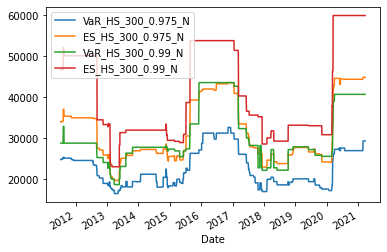

In [10]:
df_VaR_HS.plot()

In [11]:
def FHS_EWMA(absolute_weights: np.ndarray, df_losses:pd.DataFrame,confidence_levels:list, lambd:float)->pd.DataFrame:
    burn_window = 100
    moving_window = 300

    # Get burn window variance
    sigma2_0 = df_losses[:burn_window].var()

    # Create numpy arrays to hold values
    sigma2 = np.zeros(shape=(len(df_losses)+1, len(df_losses.columns)))
    Z_t = np.zeros(shape=(len(df_losses), len(df_losses.columns)))

    # Assign variance
    sigma2[burn_window,:] = sigma2_0

    # Generate Z_t
    for t in range(burn_window, len(df_losses)):
        sigma2[t+1,:] = lambd * sigma2[t,:] + (1-lambd) * df_losses.iloc[t]**2
        Z_t[t] = (df_losses.iloc[t].values / np.sqrt(sigma2[t,:]))

    aVaR = np.zeros(shape=(len(df_losses), 2))
    aES = np.zeros(shape=(len(df_losses), 2))
    for t in range(burn_window+moving_window, len(df_losses)):
        X_ft = Z_t[t-moving_window:t] * np.sqrt(sigma2[t+1,:])
        PnL = np.sum(X_ft * absolute_weights, axis=1)
        for level in range(len(confidence_levels)):
            aVaR[t,level] = empirical_var(PnL, alpha=confidence_levels[level])
            aES[t, level] = empirical_es(PnL, alpha=confidence_levels[level])

    df_VaR = pd.DataFrame(columns=['VaR_FHS_300_0.975_N', 'VaR_FHS_300_0.99_N', 'ES_FHS_300_0.975_N', 'ES_FHS_300_0.99_N'], index=df_losses.index)
    df_VaR.iloc[:,:] = np.concatenate((aVaR, aES), axis=1) 
    return sigma2,df_VaR   


In [12]:
df_VaR_FHS = FHS_EWMA(absolute_weights, df_losses,0.03,[300])

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [ ]:
def VaR_CCC(absolute_weights, df_losses, split_dates):
    confidence_levels = [0.975, 0.99]
    # This kind of dict lets you initiate a key and append to it simultaneously
    rolling_var = collections.defaultdict(list)
    rolling_es = collections.defaultdict(list)
    # Store forecasted conditional volatilities on a rolling window basis
    rolling_forecasted_volatilities = pd.DataFrame()
    # Store rolling correlation matrix
    rolling_corr_matrix = collections.defaultdict(list)
    # Year 1 and 2 are used to estimate the VaR for year 3,# Year 2 and 3 are used to estimate the VaR for year 4,# Etc.
    df_returns = df_losses * absolute_weights
    for i in range(len(split_dates) - 3):
        # Forecast volatilities with a rolling window using a GARCH(1,1)
        forecasted_volatility = pd.DataFrame(
            index=df_returns[split_dates[i+2]:split_dates[i+3]].index)
        for instrument in df_losses.columns:
            garch11 = arch_model(df_losses[instrument],
                                 p=1, q=1, dist='Normal', vol='Garch', mean='Zero')
            res = garch11.fit(
                update_freq=10, last_obs=split_dates[i+2], disp='off', show_warning=False)
            forecasts = res.forecast(horizon=1, start=split_dates[i+2])
            forecasted_variance = forecasts.variance[split_dates[i+2]
                :split_dates[i+3]]
            forecasted_volatility[instrument] = np.sqrt(forecasted_variance)

        # Append the forecasted year to the rolling_forecasted_volatilities dataframe
        rolling_forecasted_volatilities = rolling_forecasted_volatilities.append(
            forecasted_volatility)
        # Append rolling correlation matrix to list
        rolling_corr = df_returns[split_dates[i]:split_dates[i+2]].corr()
        rolling_corr_matrix[split_dates[i+3]].append(rolling_corr)

    # Use the conditional volatilities and correlations matrices to calculate the VaR and ES,# The approach is similar to the var-covar method in that the covariance matrix is used,# to calculate VaR and ES.
    var_975_1d_ccc = []
    var_990_1d_ccc = []
    es_975_1d_ccc = []
    es_990_1d_ccc = []
    for index, row in rolling_forecasted_volatilities.iterrows():
        # For each conditional volatility in the dataframe calculate the VaR and ES
        vola = np.array(row)
        # Refresh the correlation matrix each year
        for date in list(rolling_corr_matrix.keys())[0:10]:
            if index < dt.date.fromisoformat(date):
                cons_corr = rolling_corr_matrix.get(date)
                break
        cov = vola * vola * cons_corr[0]
        # print(cov)
        ccc_std_euro = np.sqrt(
            absolute_weights.T.dot(cov).dot(absolute_weights))
        var_975_1d_ccc_value = normal_var(0, ccc_std_euro, confidence_levels[0])
        var_990_1d_ccc_value = normal_var(0, ccc_std_euro, confidence_levels[1])
        es_975_1d_ccc_value = normal_es(0, ccc_std_euro, confidence_levels[0])
        es_990_1d_ccc_value = normal_es(0, ccc_std_euro, confidence_levels[1])
        var_975_1d_ccc.append(var_975_1d_ccc_value)
        var_990_1d_ccc.append(var_990_1d_ccc_value)
        es_975_1d_ccc.append(es_975_1d_ccc_value)
        es_990_1d_ccc.append(es_990_1d_ccc_value)

    # Store estimates in dataframe
    ccc = pd.DataFrame(data=[var_975_1d_ccc, var_990_1d_ccc,es_975_1d_ccc, es_990_1d_ccc]).transpose()
    ccc.columns = ['VaR_CCC_1D_0.975_N', 'VaR_CCC_1D_0.99_N',
                   'ES_CCC_1D_0.975_N', 'ES_CCC_1D_0.99_N']
    
    ccc = ccc.set_index(rolling_forecasted_volatilities.index)

    return ccc

In [ ]:
split_dates = ['2010-01-01', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', "2021-04-01"]
df_VaR_CCC = VaR_CCC(absolute_weights, df_losses, split_dates)


## Backtesting

In [ ]:
backtest = pd.DataFrame(index = df_losses.index)
backtest['Losses'] = np.sum(df_losses * absolute_weights, axis=1)
backtest = pd.concat([backtest,df_VaR_VC,df_VaR_HS, df_VaR_FHS, df_VaR_CCC], axis=1)

In [ ]:
len(backtest)
len(df_VaR_FHS)


In [ ]:
backtest = backtest.dropna()

In [ ]:
backtest

In [ ]:
# Initialize dataframe to store test statistics
zscores = pd.DataFrame()

# Initialize dict to store pvalues
var_pvalues = {}

# Initialize Violations
violation = pd.DataFrame(index = backtest.index)


# For each measure, add a column that only contains the losses that violated the corresponding VaR
for measure in backtest.iloc[:,1:]:
    
    # Define column name for the violation colums per method
    measure_violation = str(measure) + '_violations'
    
    backtest[measure_violation] = np.where(backtest['Losses'] > backtest[measure], backtest['Losses'], 'NaN')
    violation[measure_violation] = np.where(backtest['Losses'] > backtest[measure], 1, 0)
    backtest[measure_violation] = backtest[measure_violation].astype(float)
    
    # Apply appropriate alpha
    if measure.split('_')[3] == '0.975':
        alpha = (1-confidence_levels[0])
    elif measure.split('_')[3] == '0.99':
        alpha = (1-confidence_levels[1])
    
    # Calculate test statistic based on markdown above
    N = len(backtest)
    violations = backtest[measure_violation].count()
    expected = N * (alpha)
    
    zscore = (violations - expected) / np.sqrt(N * alpha * (1 - alpha))
    pvalue = norm.sf(abs(zscore)) * 2    # P-value is two sided
    
    var_pvalues[measure] = pvalue
    
    zscores[measure] = [zscore, pvalue]
    
    print (measure)
    print ('Z-score: {:.3f}'.format(zscore))
    print ('P-value: {:.3f}'.format(pvalue))
    print ()

In [ ]:
violation['Trading Days'] = 1
violation['Expected 0.975'] = 1*(1-0.975)
violation['Expected 0.99'] = 1*(1-0.99)

In [ ]:
violation[violation.columns[violation.columns.str.contains(f'(?=.*VaR)(?=.*0.975)',regex=True)]]

In [ ]:
df_violations=np.ceil(violation[violation.columns[violation.columns.str.contains(f'(?=.*VaR)(?=.*0.975)',regex=True) | violation.columns.str.contains(f'(?=.*Days)',regex=True) | violation.columns.str.contains(f'(?=.*Expected)(?=.*0.975)',regex=True)]].groupby(pd.Grouper(freq="y")).sum().T,0)
df_violations

In [ ]:
print(df_violations.to_latex())

In [ ]:
z=zscores
z

In [ ]:
print(z.to_latex())

In [ ]:
df_violations_1=np.ceil(violation[violation.columns[violation.columns.str.contains(f'(?=.*VaR)(?=.*0.99)',regex=True) | violation.columns.str.contains(f'(?=.*Days)',regex=True) | violation.columns.str.contains(f'(?=.*Expected)(?=.*0.99)',regex=True)]].groupby(pd.Grouper(freq="y")).sum().T,0)

In [ ]:
print(df_violations_1.to_latex())

In [ ]:
# Plot violations to observe clustering
for measure in backtest.columns[1:20]:

    measure_violation = str(measure) + '_violations'
    
    # Use the backtest period as index
    x = backtest.index
    y1 = backtest['Losses']
    y2 = backtest[measure_violation]
    y3 = backtest[measure]
    
    fig, ax = plt.subplots(figsize=(20, 7))

    plt.title('Violations under {} method'.format(measure), size=16)

    # Plot returns in euro
    plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
    
    # Mark the violations
    plt.scatter(x, y2, marker='x', color='black', label = 'Violations')
    
    # Plot VaR
    plt.plot(x, y3, color='red', label = 'VaR')
        
    plt.legend()
    plt.ylim(0,100000)
    plt.show()
   

In [ ]:
(backtest['VaR_HS_300_0.975_N'] == backtest['VaR_FHS_300_0.975_N']).value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(backtest['VaR_HS_300_0.975_N'], label='HS')
plt.plot(backtest['VaR_FHS_300_0.975_N'], label='FHS')
plt.legend()
plt.show()

In [ ]:

x = backtest.index
y1 = backtest['Losses'] / 1000000
y2 = backtest['VaR_VC_300_0.975_N'] / 1000000
y3 = backtest['VaR_VC_300_0.975_t5'] / 1000000
y4 = backtest['VaR_HS_300_0.975_N'] / 1000000
y5 = backtest['VaR_FHS_300_0.975_N'] / 1000000
y6 = backtest['VaR_CCC_1D_0.975_N'] / 1000000

fig, ax = plt.subplots(figsize=(20, 10))

plt.ylabel('Losses in \u20ac millions', size=16)
plt.tick_params(labelsize=16)

# Plot returns in euro
plt.plot(x, y1, color='lightgrey', label = '\u20ac Losses')
plt.plot(x, y2, color='#3869B1', label = '$VC_{norm}$')
# plt.plot(x, y3, color='#DA7E30', label = '$VC-t_5$')
plt.plot(x, y4, color='#3F9852', label = '$HS$')
plt.plot(x, y5, color='#CC2428', label = '$FHS$')
# plt.plot(x, y6, color='#535055', label = '$CCC$')

plt.legend(fontsize=13)
plt.ylim(0,0.1)
plt.show()

## Historical simulation for different horizons

In [ ]:
pf_losses = pd.DataFrame(np.sum(df_losses * absolute_weights, axis=1), columns=['1D'])
pf_losses['Day'] = (np.arange(1, len(pf_losses)+1)).astype('int32')

In [ ]:
for idx, row in pf_losses.iterrows():
    if row['Day'] % 5 == 0:
        pf_losses.loc[idx, '5D'] = np.sum(pf_losses.loc[pf_losses.index[int(row['Day']-5)]:pf_losses.index[int(row['Day']-1)], '1D'])

    if row['Day'] % 10 == 0:
        pf_losses.loc[idx, '10D'] = np.sum(pf_losses.loc[pf_losses.index[int(row['Day']-10)]:pf_losses.index[int(row['Day']-1)], '1D'])

In [ ]:
print(np.percentile(pf_losses[:'2021-03-16']['1D'], confidence_levels[0] * 100) * np.sqrt(5))
print(np.percentile(pf_losses[:'2021-03-16']['5D'].dropna(), confidence_levels[0] * 100))

print(np.percentile(pf_losses[:'2021-03-16']['1D'], confidence_levels[0] * 100) * np.sqrt(10))
print(np.percentile(pf_losses[:'2021-03-16']['10D'].dropna(), confidence_levels[0] * 100))